In [1]:
import os
import logging

logging.disable()
date = '2019-11-19'
data_location = '/user/simon/data/soar/flat_analisis_2019B/'
full_path_data_location = os.path.join(data_location, date)
# "2019-08-06"
# "2019-08-10"
# "2019-08-23"
# "2019-09-04"
# "2019-09-06"
# "2019-09-22"
# "2019-09-23"
# "2019-10-05"
# "2019-10-08"
# "2019-10-20"
# "2019-11-02"
# "2019-11-19"
# "2019-11-29"
# "2019-12-03"
# "2019-12-15"
# "2019-12-18"
# "2019-12-19"
# "2020-01-02"
# "2020-01-19"
# "2020-01-31"


In [2]:
import os
from ccdproc import ImageFileCollection, CCDData, subtract_bias
KEYWORDS = ['slit',
            'grating',
            'cam_targ',
            'grt_targ',
            'filter',
            'filter2',
            'gain',
            'roi',
            'wavmode',
            'exptime',
            'rdnoise',
            'ccdsum']

def get_flat_files_as_pandas_dataframe():
    ifc = ImageFileCollection(location=full_path_data_location, keywords=KEYWORDS, glob_include='*FLAT*')
    df = ifc.summary.to_pandas()
    groups = df.groupby(['slit',
                         'grating',
                         'cam_targ',
                         'grt_targ',
                         'filter',
                         'filter2',
                         'gain',
                         'roi',
                         'wavmode',
                         'exptime',
                         'rdnoise',
                         'ccdsum']).size().reset_index().rename(
        columns={0: 'count'})
    all_groups = []
    for i in groups.index:
        conf_group = df[((df['slit'] == groups.iloc[i]['slit']) &
                         (df['grating'] == groups.iloc[i]['grating']) &
                         (df['cam_targ'] == groups.iloc[i]['cam_targ']) &
                         (df['grt_targ'] == groups.iloc[i]['grt_targ']) &
                         (df['filter'] == groups.iloc[i]['filter']) &
                         (df['filter2'] == groups.iloc[i]['filter2']) &
                         (df['gain'] == groups.iloc[i]['gain']) &
                         (df['roi'] == groups.iloc[i]['roi']) &
                         (df['wavmode'] == groups.iloc[i]['wavmode']) &
                         (df['exptime'] == groups.iloc[i]['exptime']) &
                         (df['rdnoise'] == groups.iloc[i]['rdnoise']) &
                         (df['ccdsum'] == groups.iloc[i]['ccdsum']))]
        if len(conf_group) > 2:
            all_groups.append(conf_group.sort_values(by='file'))
        else:
            print("Group's length: {}".format(len(conf_group)))
            for __File in conf_group.file.values.tolist():
                print("Discarding File: {}".format(__File))
    return all_groups

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def visualize_as_grid(group, date):
    group_name = "Date: {} Wavemode: {} Exptime: {}s".format(date, group.wavmode.unique()[0], group.exptime.unique()[0])
    nrows = int(np.ceil(len(group)/2.))
    ncols = 2
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize = (16, nrows * 3 ))
   
    fig = plt.figure(figsize = (16, nrows * 3 ))
    fig.suptitle(group_name, fontsize=16)
    gs = fig.add_gridspec(ncols=ncols, nrows=nrows)
    for i, fits_file in enumerate(group.file.tolist()):
        ccd = CCDData.read(os.path.join(full_path_data_location, fits_file), unit='adu')
        z1 = np.mean(ccd.data) - 0.5 * np.std(ccd.data)
        z2 = np.median(ccd.data) + np.std(ccd.data)
        if i%2 == 0:
            y=0
        else:
            y=1
        ax_x = fig.add_subplot(gs[int(np.floor(i/2.)), y])
        ax_x.imshow(ccd.data, clim=(z1, z2), cmap='viridis')
        ax_x.title.set_text(fits_file)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])

##  Analisys


In [4]:

groups = get_flat_files_as_pandas_dataframe()

### Visual Inspection

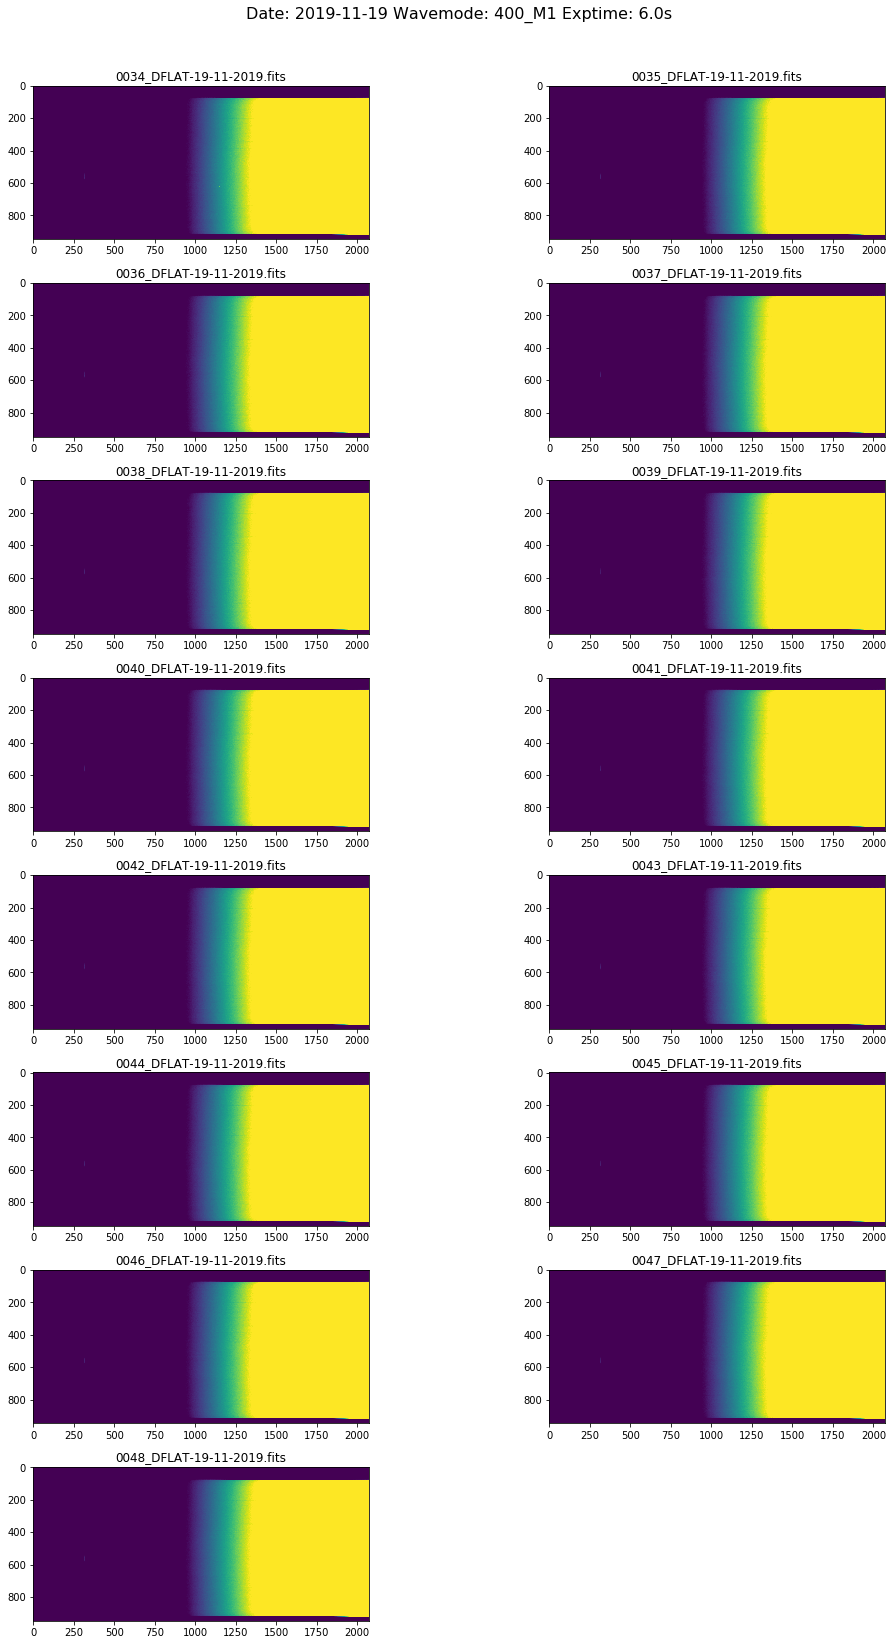

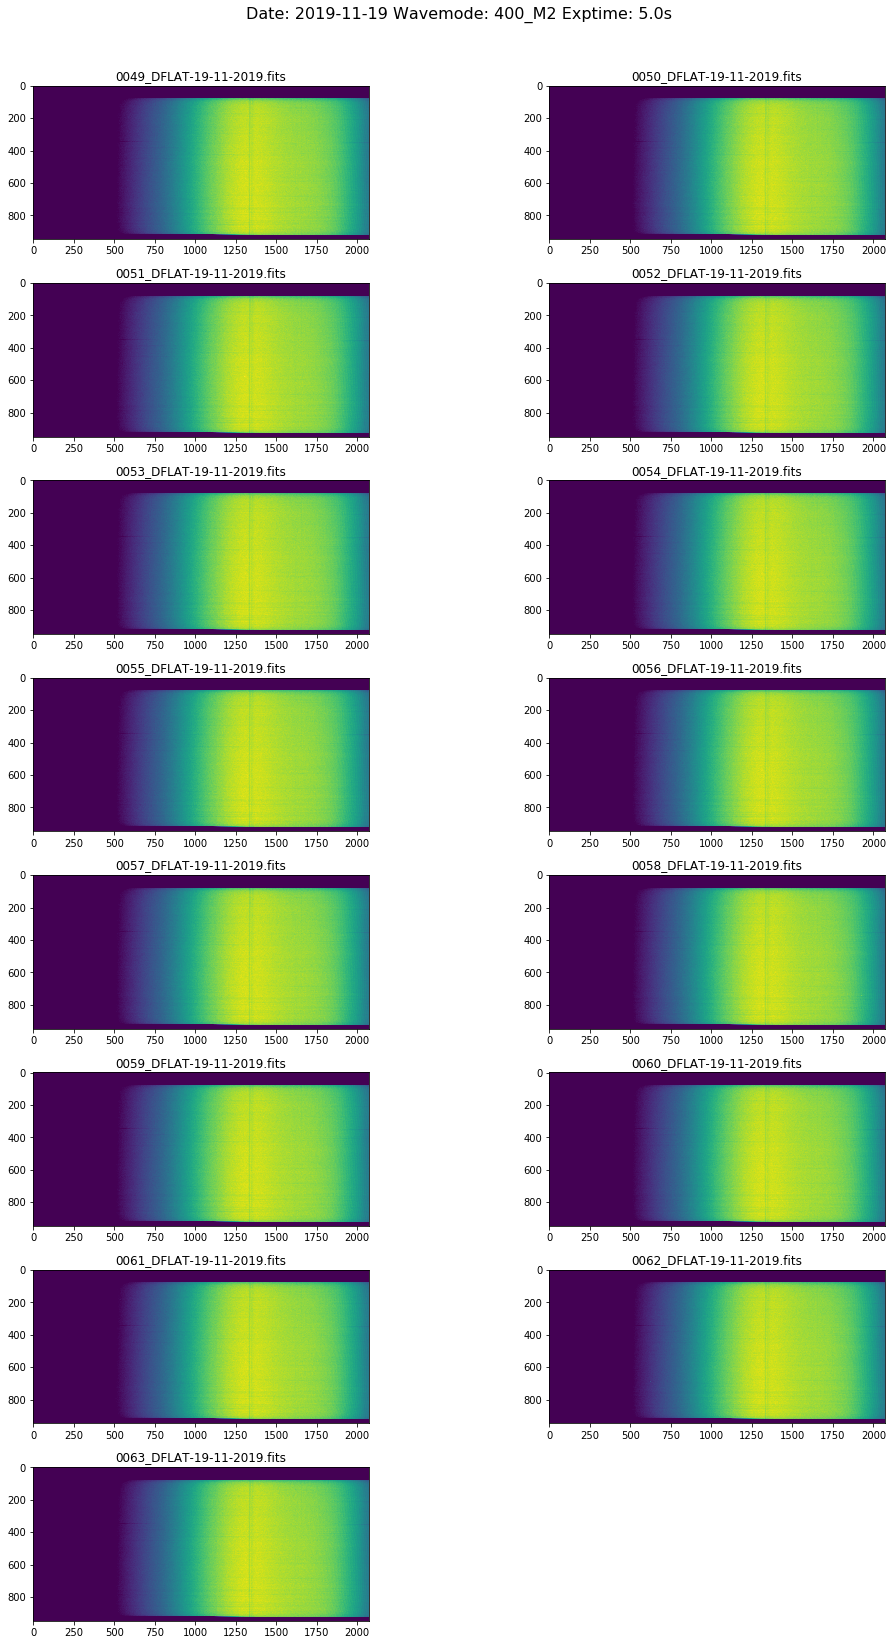

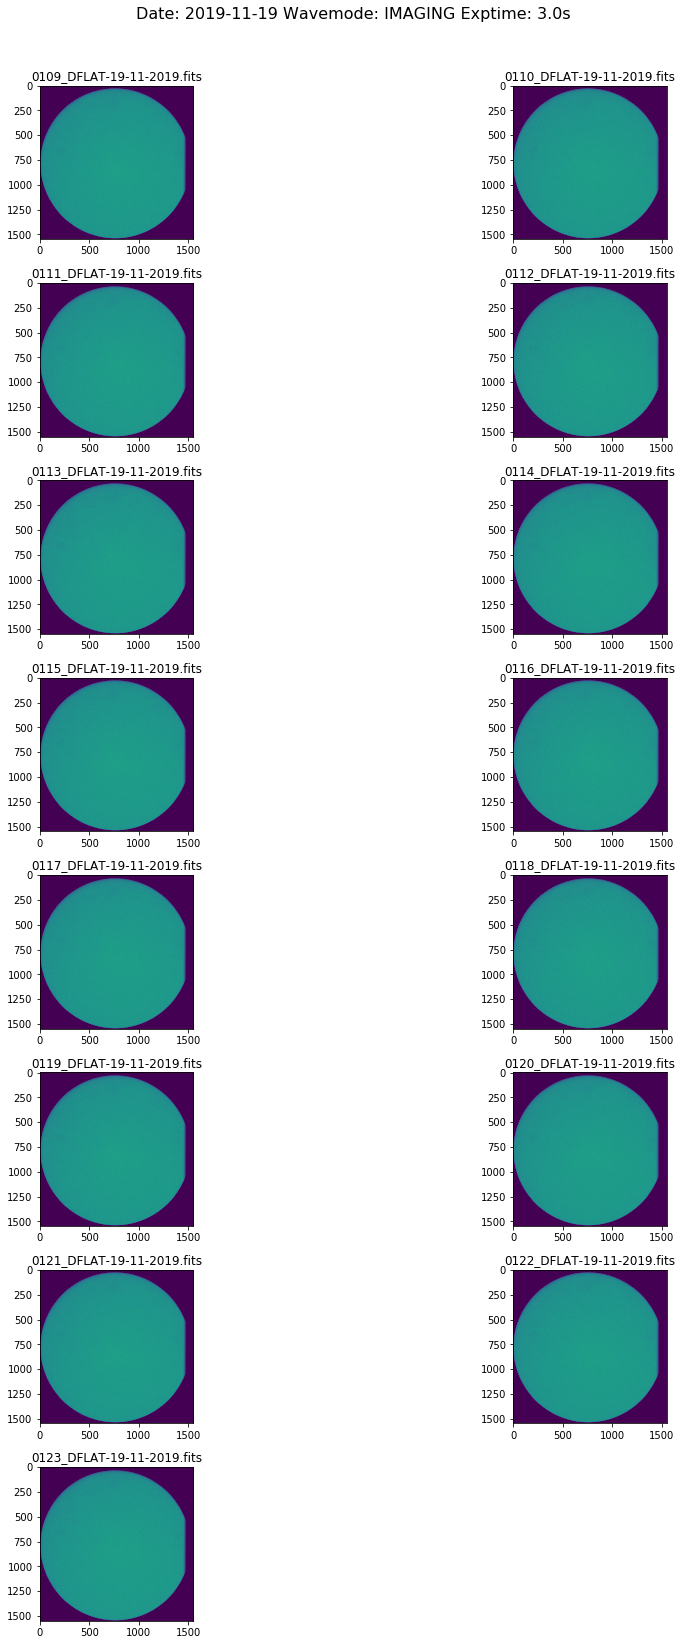

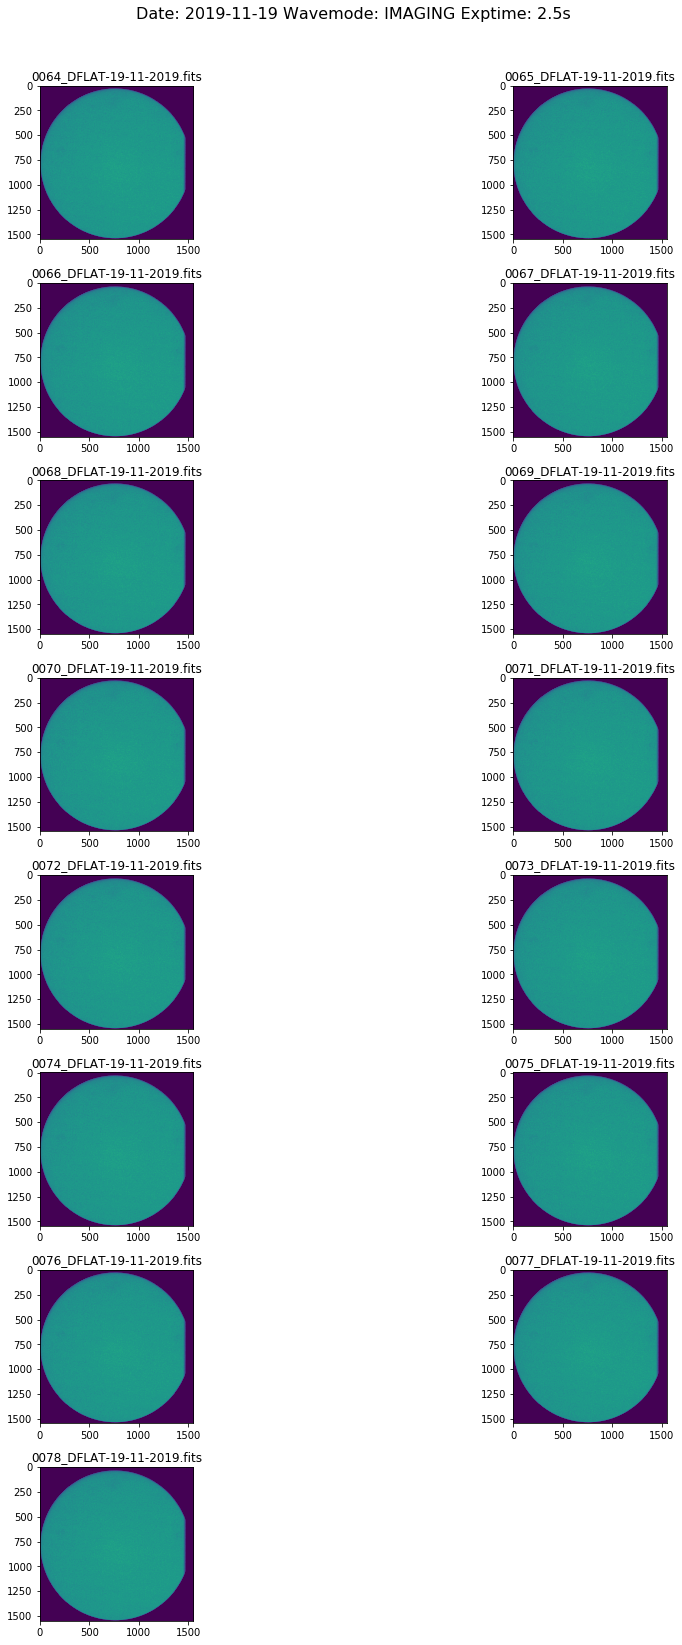

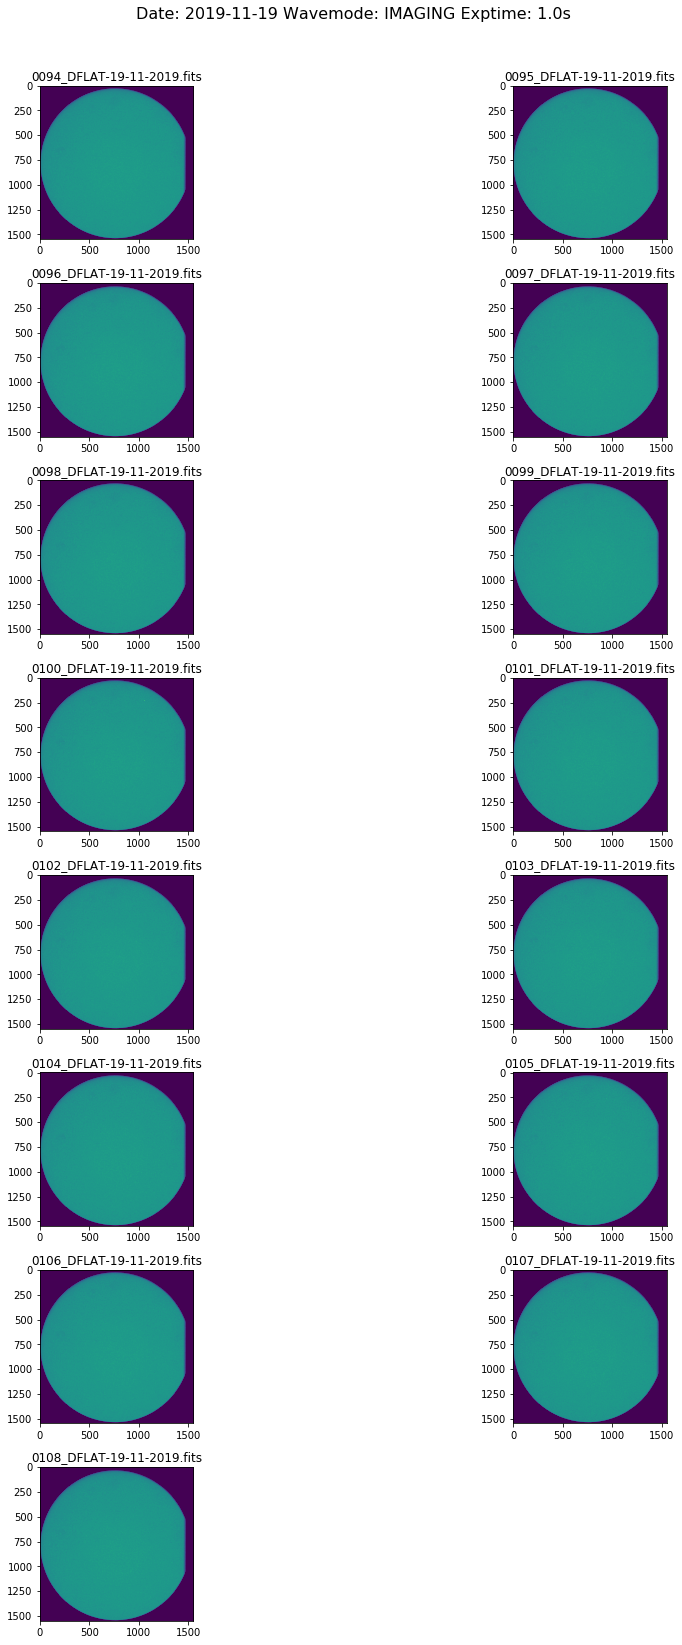

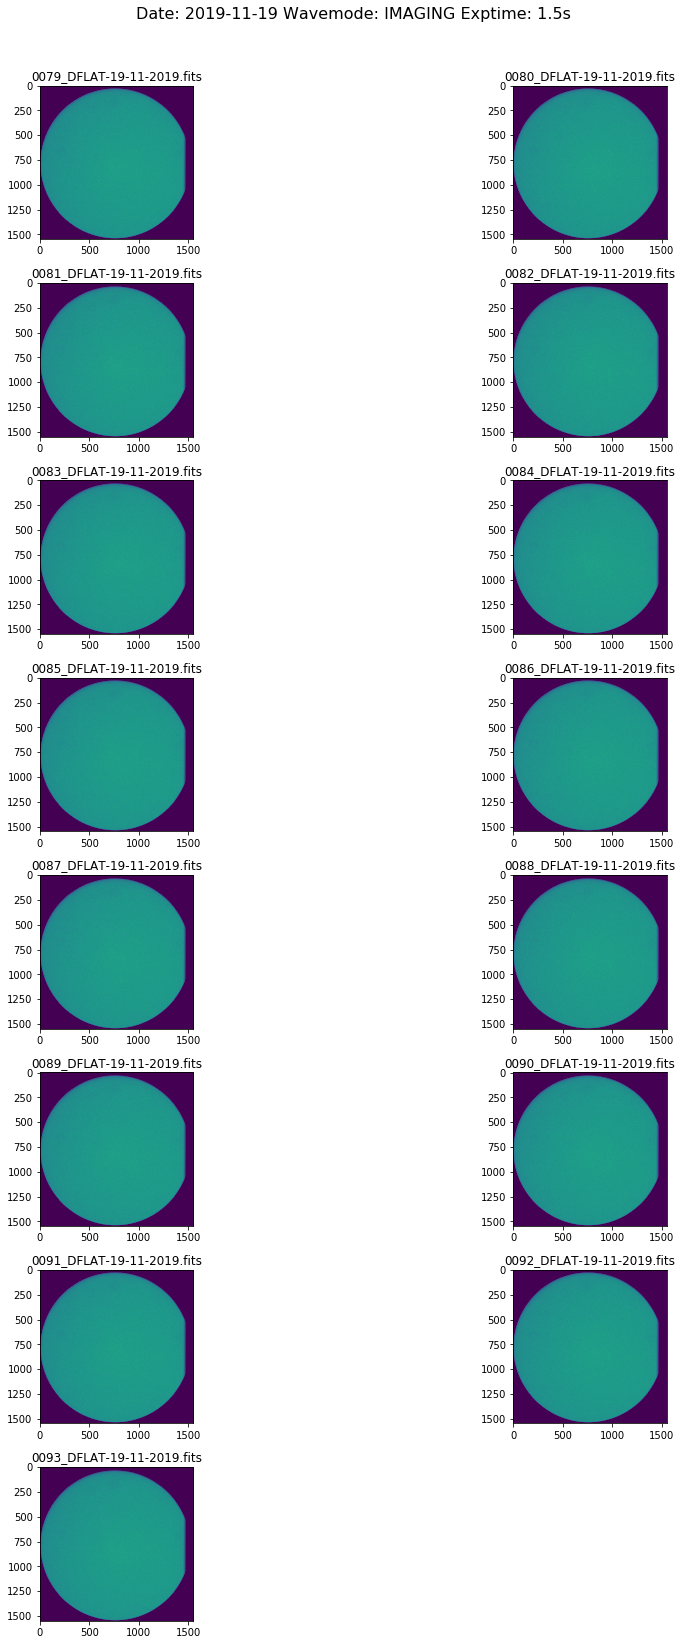

In [5]:
for group in groups:
    visualize_as_grid(group=group, date=date)

### Combine as MasterFlats

In [6]:
import re
def identify_technique(ccd):
    if 'Spectroscopic' in ccd.header['ROI'] or \
            ccd.header['OBSTYPE'] in ['ARC', 'SPECTRUM', 'COMP'] or \
            ccd.header['SLIT'] not in ['NO_MASK', '<NO MASK>'] or \
            ccd.header['GRATING'] not in ['NO_GRATING', '<NO GRATING>'] or \
            '_SP_' in ccd.header['OBJECT']:
        technique = 'Spectroscopy'
    elif 'Imaging' in ccd.header['ROI'] or \
            ccd.header['OBSTYPE'] in ['EXPOSE'] or\
            ccd.header['WAVMODE'] == 'IMAGING' or '_IM_' in ccd.header['OBJECT']:
        technique = 'Imaging'
    else:
        technique = 'Unknown'
    return technique


In [7]:
# !pip install goodman_pipeline==1.3.0rc3

In [8]:
import goodman_pipeline
import glob

print(goodman_pipeline.__version__)

from goodman_pipeline.core import create_master_flats, get_overscan_region, define_trim_section, get_slit_trim_section

1.3.0rc3


In [9]:
def combine_flats(group):
    new_data = []
    file_list = group.file.tolist()
    sample_file = os.path.join(data_location, date, file_list[0])
    sample_ccd = CCDData.read(sample_file, unit='adu')
    technique = identify_technique(ccd=sample_ccd)
    
    
    
    overscan_region = get_overscan_region(sample_image=sample_file, technique=technique)
    trim_section = define_trim_section(sample_image=sample_file, technique=technique)
    if technique == 'Spectroscopy':
        new_master_flat_name = "master_flat_{}_{}.fits".format(
            re.sub(' ', '_', sample_ccd.header['WAVMODE']),
            re.sub('[<> ]', '', sample_ccd.header['FILTER2']))
        print(new_master_flat_name)
        master_bias_name = "master_bias_{}_SP_{}x{}_R{:05.2f}_G{:05.2f}.fits".format(sample_ccd.header['INSTCONF'].upper(),
                                                                                     sample_ccd.header['CCDSUM'].split()[0],
                                                                                     sample_ccd.header['CCDSUM'].split()[1],
                                                                                     sample_ccd.header['RDNOISE'],
                                                                                     sample_ccd.header['GAIN'])
        master_bias_file = os.path.join(data_location, date, 'master_bias', master_bias_name)
        print(master_bias_file)
    else:
        new_master_flat_name = "master_flat_{}_{}.fits".format(
            re.sub(' ', '_', sample_ccd.header['WAVMODE']),
            re.sub('[<> ]', '', sample_ccd.header['FILTER']))
        print(new_master_flat_name)
        master_bias_name = "master_bias_{}_IM_{}x{}_R{:05.2f}_G{:05.2f}.fits".format(sample_ccd.header['INSTCONF'].upper(),
                                                                                     sample_ccd.header['CCDSUM'].split()[0],
                                                                                     sample_ccd.header['CCDSUM'].split()[1],
                                                                                     sample_ccd.header['RDNOISE'],
                                                                                     sample_ccd.header['GAIN'])
        master_bias_file = os.path.join(data_location, date, 'master_bias', master_bias_name)
        print(master_bias_file)
        
    if not os.path.isfile(master_bias_file):
        print("Master Bias {} does not exists".format(master_bias_file))
        master_bias_file = ''
        ignore_bias = True
        print("Ignoring bias!")
    else:
        print("Found master bias: {}".format(master_bias_file))
        ignore_bias = False
    
    master_flat, master_flat_name = create_master_flats(
        flat_files=file_list, 
        raw_data=os.path.join(data_location, date), 
        reduced_data=os.path.join(full_path_data_location, 'master_flats'), 
        technique=technique, 
        overscan_region=overscan_region, 
        trim_section=trim_section, 
        master_bias_name=master_bias_file, 
        new_master_flat_name=new_master_flat_name, 
        saturation_threshold=1, 
        ignore_bias=ignore_bias,)
    if technique == 'Spectroscopy':
        trim_section = get_slit_trim_section(master_flat=master_flat)
        
        master_flat = goodman_pipeline.core.image_trim(ccd=master_flat, trim_section=trim_section, trim_type='slit')
        master_flat.write(master_flat_name, overwrite=True)
        divider = 2.
    else:
        divider = 1.
    
    fig, ax = plt.subplots(figsize=(16, int(16/divider)))
    ax.title.set_text(os.path.basename(master_flat_name))
    z1 = np.mean(master_flat.data) - 0.5 * np.std(master_flat.data)
    z2 = np.median(master_flat.data) + np.std(master_flat.data)
    ax.imshow(master_flat.data, clim=(z1, z2), cmap='viridis')
    plt.show()
    print(master_flat_name)
    return technique, master_flat

master_flat_400_M1_NO_FILTER.fits
/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits


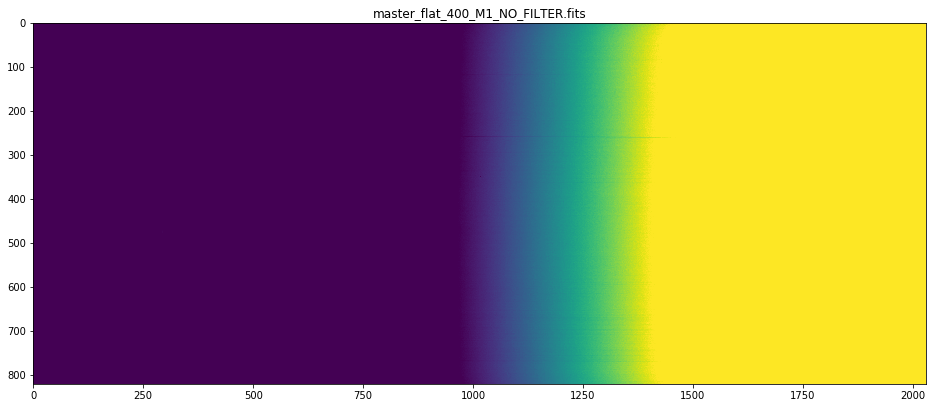

/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_flats/master_flat_400_M1_NO_FILTER.fits
master_flat_400_M2_GG455.fits
/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_SP_2x2_R03.89_G01.48.fits


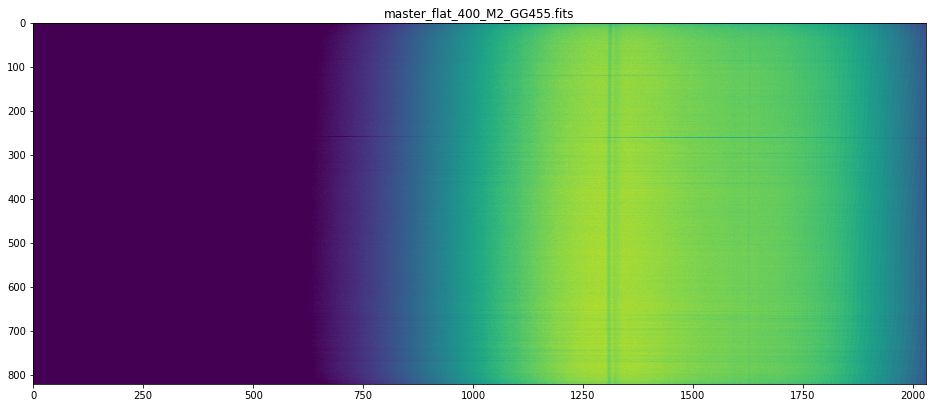

/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_flats/master_flat_400_M2_GG455.fits
master_flat_IMAGING_VR.fits
/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


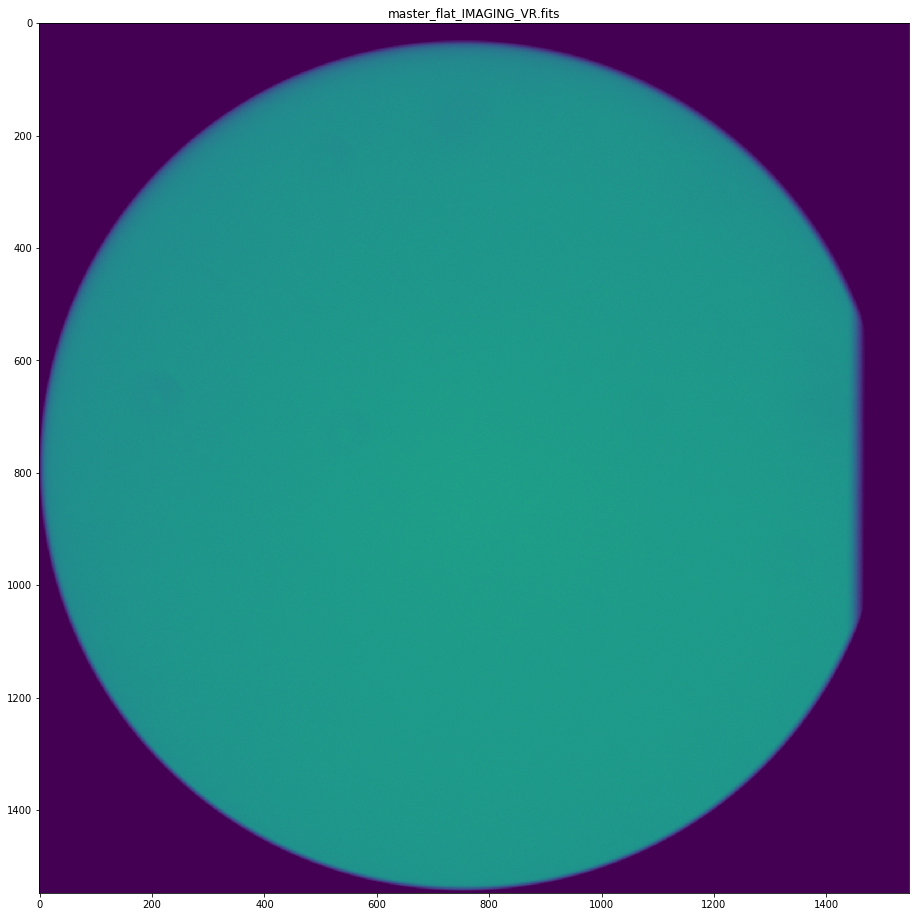

/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_flats/master_flat_IMAGING_VR.fits
master_flat_IMAGING_g-SDSS.fits
/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


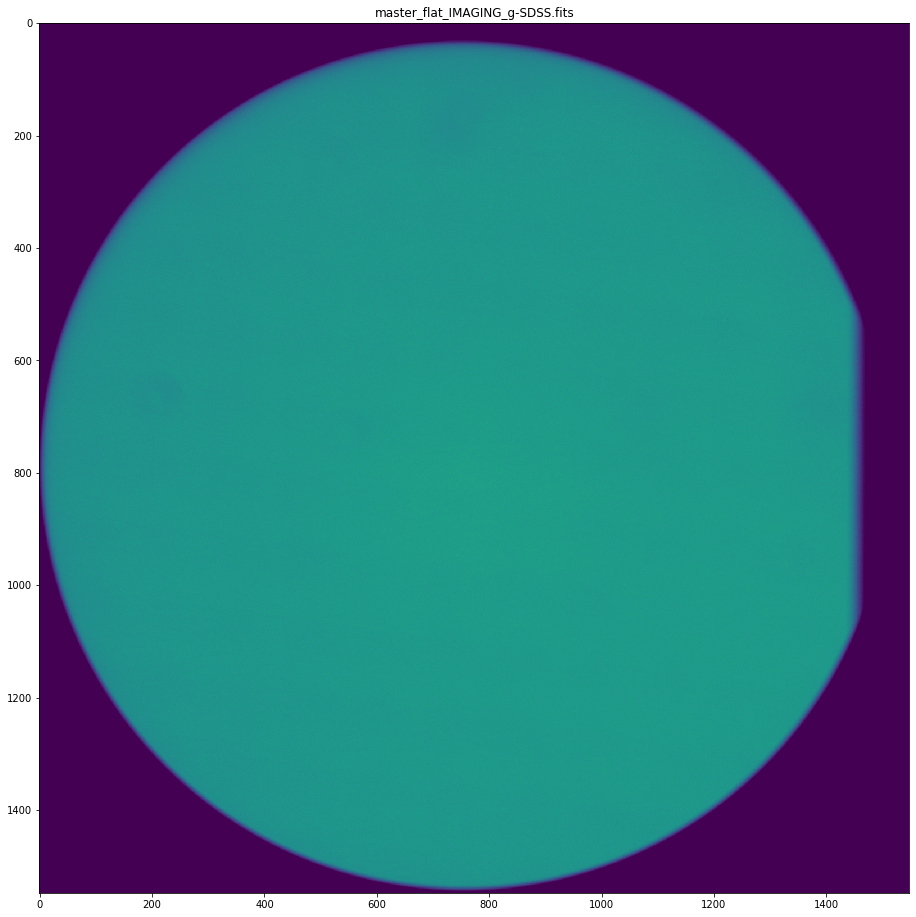

/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_flats/master_flat_IMAGING_g-SDSS.fits
master_flat_IMAGING_i-SDSS.fits
/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


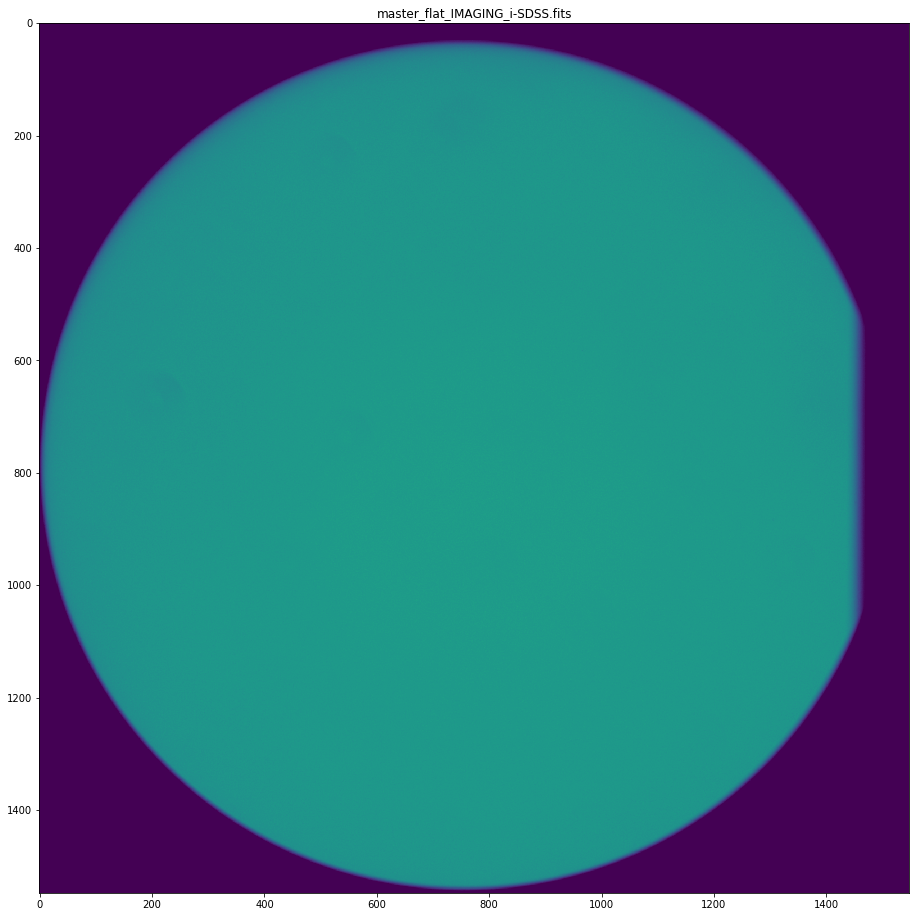

/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_flats/master_flat_IMAGING_i-SDSS.fits
master_flat_IMAGING_r-SDSS.fits
/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits
Found master bias: /user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_bias/master_bias_RED_IM_2x2_R03.89_G01.48.fits


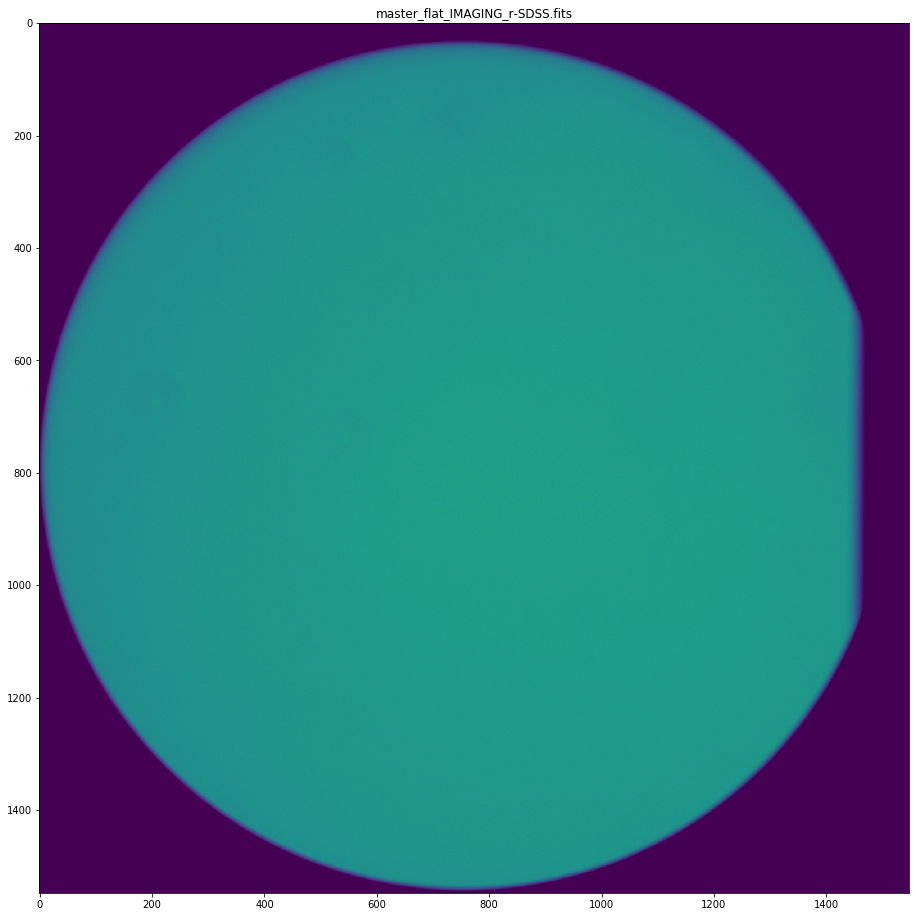

/user/simon/data/soar/flat_analisis_2019B/2019-11-19/master_flats/master_flat_IMAGING_r-SDSS.fits


In [10]:
all_data = []
for group in groups:
    technique, master_flat = combine_flats(group=group)
    all_data.append([group, technique, master_flat])

### Statistics


In [11]:
import logging

logger = logging.getLogger(__name__)
logger.propagate = False

In [12]:
%matplotlib inline

Spectroscopy Group Filter2: NO_FILTER Grating: 400_SYZY Slit: 1.0_LONG_SLIT Wavmode: 400_M1
Spectroscopy Group Filter2: GG455 Grating: 400_SYZY Slit: 1.0_LONG_SLIT Wavmode: 400_M2
Imaging Group Filter: VR
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)
[724:823, 724:823]
(1548, 1548)
(100, 100)


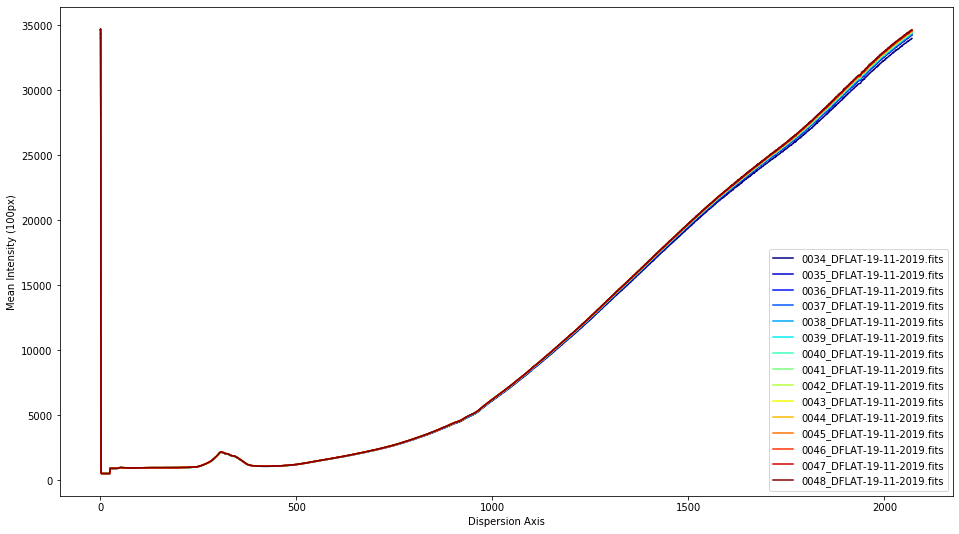

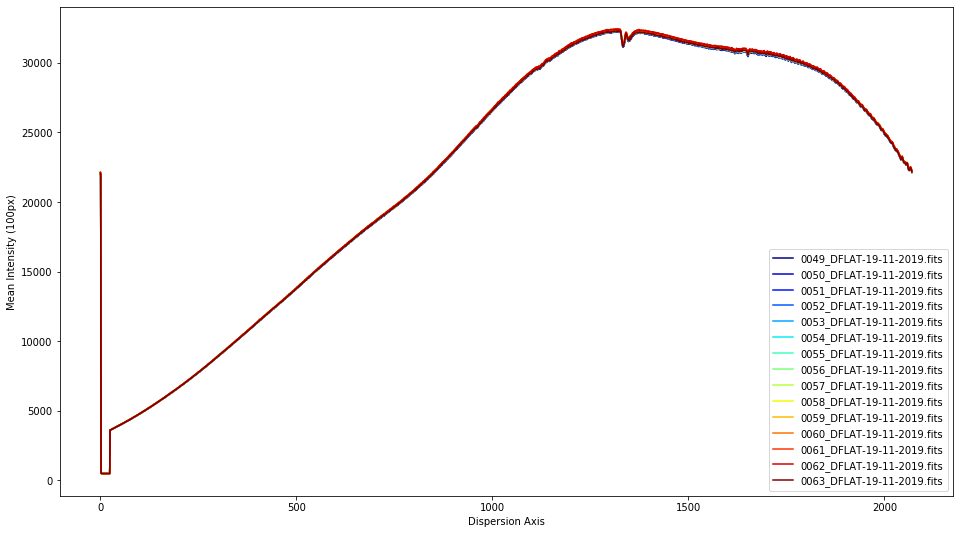

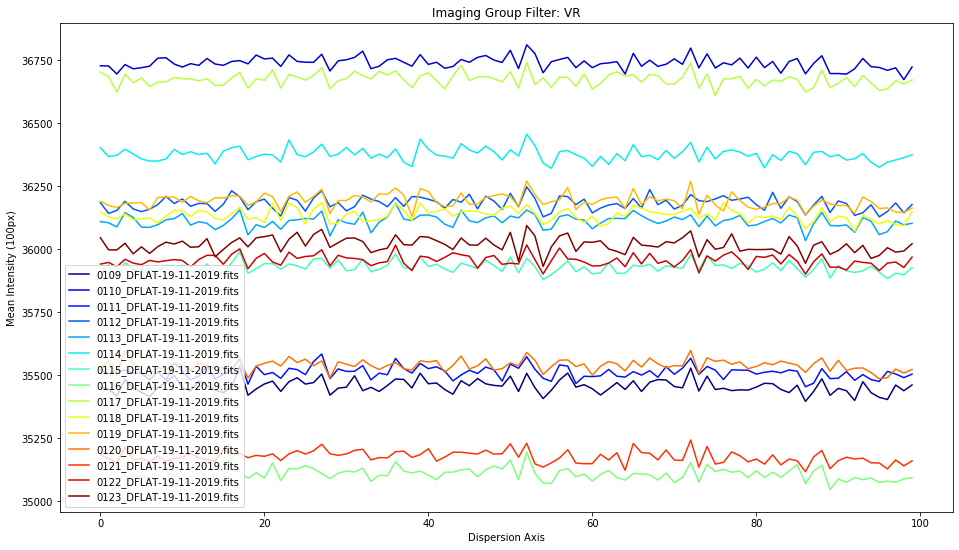

                          file   npix        mean      stddev    min    max
0   0109_DFLAT-19-11-2019.fits  10000  35456.2311  263.005831  30720  36457
1   0110_DFLAT-19-11-2019.fits  10000  36738.6441  267.809913  32093  37784
2   0111_DFLAT-19-11-2019.fits  10000  35511.4556  263.158982  30816  36479
3   0112_DFLAT-19-11-2019.fits  10000  36181.7342  265.941312  31379  37283
4   0113_DFLAT-19-11-2019.fits  10000  36111.1563  266.080450  31464  37148
5   0114_DFLAT-19-11-2019.fits  10000  36374.9888  267.270100  31431  37344
6   0115_DFLAT-19-11-2019.fits  10000  35927.9573  263.407717  31292  36941
7   0116_DFLAT-19-11-2019.fits  10000  35107.9886  262.369972  30301  36121
8   0117_DFLAT-19-11-2019.fits  10000  36672.8846  268.876030  32052  37745
9   0118_DFLAT-19-11-2019.fits  10000  36134.9239  266.572578  31317  37138
10  0119_DFLAT-19-11-2019.fits  10000  36191.5480  266.191939  31516  37278
11  0120_DFLAT-19-11-2019.fits  10000  35538.6804  261.460478  30863  36649
12  0121_DFL

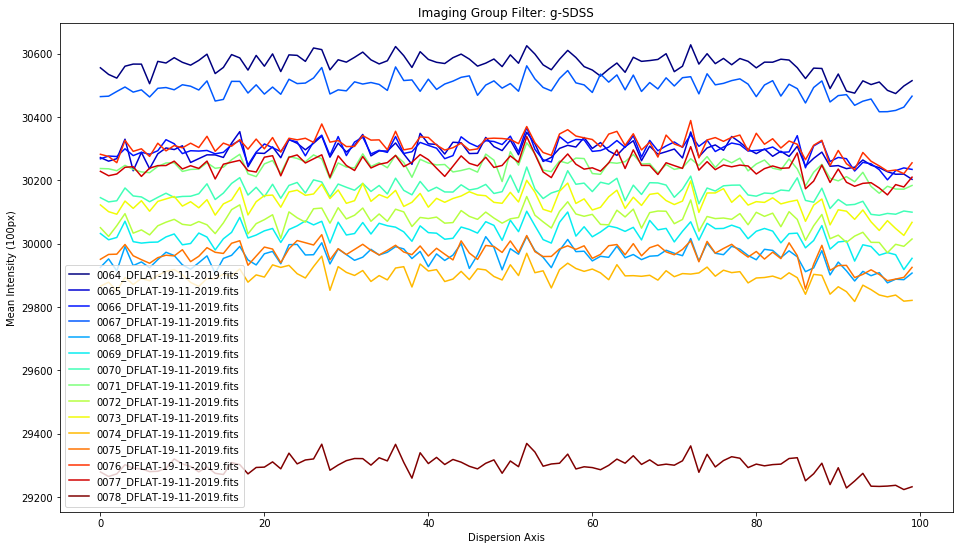

                          file   npix        mean      stddev    min    max
0   0064_DFLAT-19-11-2019.fits  10000  30565.7050  271.982812  26076  31592
1   0065_DFLAT-19-11-2019.fits  10000  30289.8234  271.106093  25908  31268
2   0066_DFLAT-19-11-2019.fits  10000  30297.4506  267.694641  26021  31235
3   0067_DFLAT-19-11-2019.fits  10000  30494.2263  269.458277  26145  31426
4   0068_DFLAT-19-11-2019.fits  10000  29956.7241  268.570747  25507  31001
5   0069_DFLAT-19-11-2019.fits  10000  30030.1742  266.860750  25590  31078
6   0070_DFLAT-19-11-2019.fits  10000  30164.2496  267.532339  25728  31161
7   0071_DFLAT-19-11-2019.fits  10000  30241.8713  269.995632  25800  31415
8   0072_DFLAT-19-11-2019.fits  10000  30070.7644  268.619255  25789  31022
9   0073_DFLAT-19-11-2019.fits  10000  30131.5841  267.189708  25861  31250
10  0074_DFLAT-19-11-2019.fits  10000  29895.3809  267.163592  25518  30832
11  0075_DFLAT-19-11-2019.fits  10000  29967.8492  269.667218  25605  31064
12  0076_DFL

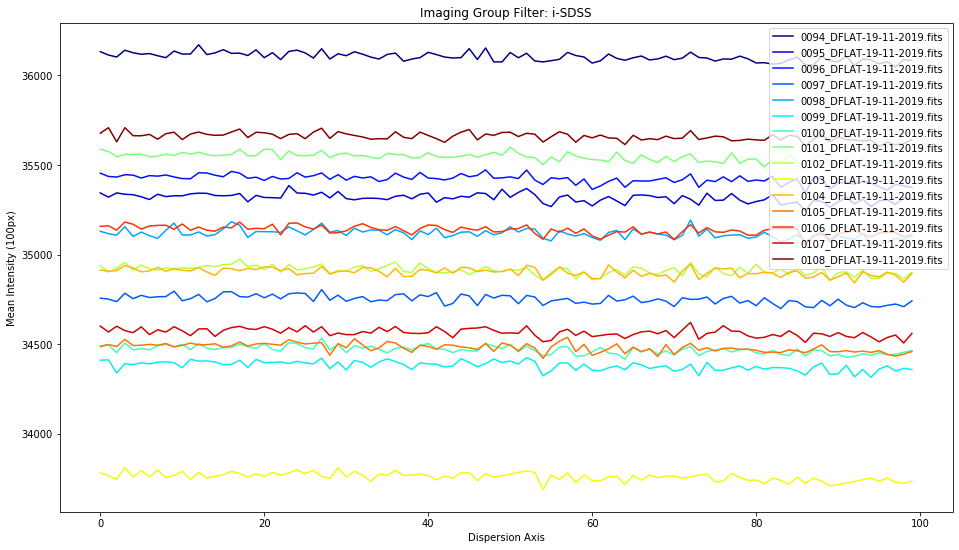

                          file   npix        mean      stddev    min    max
0   0094_DFLAT-19-11-2019.fits  10000  36103.0259  221.517422  31266  36981
1   0095_DFLAT-19-11-2019.fits  10000  35316.2324  219.270398  30558  36115
2   0096_DFLAT-19-11-2019.fits  10000  35421.4297  217.435536  30601  36236
3   0097_DFLAT-19-11-2019.fits  10000  34749.0382  217.158322  29967  35511
4   0098_DFLAT-19-11-2019.fits  10000  35115.5619  218.022680  30533  35895
5   0099_DFLAT-19-11-2019.fits  10000  34379.1998  213.299067  29673  35272
6   0100_DFLAT-19-11-2019.fits  10000  34468.2563  213.353409  29873  35218
7   0101_DFLAT-19-11-2019.fits  10000  35543.9570  219.601915  30665  36412
8   0102_DFLAT-19-11-2019.fits  10000  34911.6216  216.664480  30325  35660
9   0103_DFLAT-19-11-2019.fits  10000  33758.7416  211.758253  29110  34513
10  0104_DFLAT-19-11-2019.fits  10000  34901.1438  216.647469  30112  35783
11  0105_DFLAT-19-11-2019.fits  10000  34480.5326  214.124472  29897  35306
12  0106_DFL

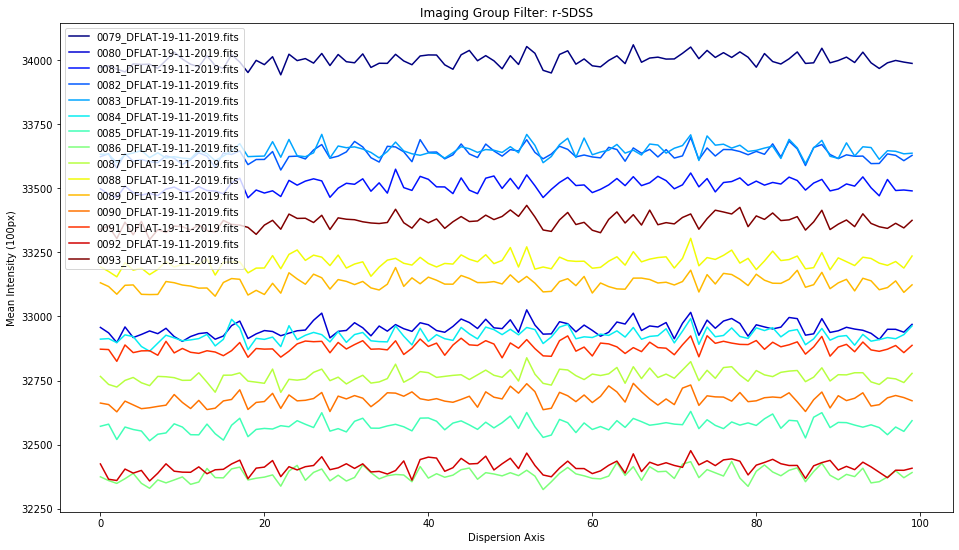

                          file   npix        mean      stddev    min    max
0   0079_DFLAT-19-11-2019.fits  10000  33998.5678  256.308087  29373  34932
1   0080_DFLAT-19-11-2019.fits  10000  32952.8061  249.172765  28619  33808
2   0081_DFLAT-19-11-2019.fits  10000  33508.8612  253.543111  28768  34437
3   0082_DFLAT-19-11-2019.fits  10000  33632.4478  254.108767  29254  34490
4   0083_DFLAT-19-11-2019.fits  10000  33645.6298  253.040223  29179  34598
5   0084_DFLAT-19-11-2019.fits  10000  32924.6661  248.932010  28415  33947
6   0085_DFLAT-19-11-2019.fits  10000  32573.6202  245.651474  28087  33466
7   0086_DFLAT-19-11-2019.fits  10000  32381.9078  244.826617  27722  33267
8   0087_DFLAT-19-11-2019.fits  10000  32766.0158  247.520455  28385  33764
9   0088_DFLAT-19-11-2019.fits  10000  33211.9195  249.881099  28740  34113
10  0089_DFLAT-19-11-2019.fits  10000  33129.1645  251.219201  28817  34164
11  0090_DFLAT-19-11-2019.fits  10000  32677.5801  248.207774  27932  33530
12  0091_DFL

In [13]:
import pandas as pd
for group, technique, master_flat in all_data:
    cmap = plt.get_cmap('jet')
    colors = [cmap(i) for i in np.linspace(0, 1, len(group))]
    if technique == 'Spectroscopy':
        print('Spectroscopy Group Filter2: {} Grating: {} Slit: {} Wavmode: {}'.format(group.filter2.unique()[0],
                                                                                       group.grating.unique()[0], 
                                                                                       group.slit.unique()[0], 
                                                                                       group.wavmode.unique()[0]))
              
        fig_1, ax_1 = plt.subplots(figsize=(16,9))
#         fig_1, ax_1 = plt.subplots()
        ax_1.set_xlabel('Dispersion Axis')
        ax_1.set_ylabel('Mean Intensity (100px)')
        
        for i, _image in enumerate(group.file.tolist()):
            ccd = CCDData.read(os.path.join(full_path_data_location, _image), unit='adu')
            x, y = ccd.data.shape
            x_0 = int(x / 2.) - 50
            x_1 = int(x / 2.) + 49
            
            y_0 = 1
            y_1 = y
            
            region = "[:, {}:{}]".format(x_0, x_1)
            ccd = goodman_pipeline.core.image_trim(ccd=ccd, trim_section=region, trim_type='subsection')
            ccd.data = np.mean(ccd.data, axis=0)
            ax_1.plot(ccd.data, color=colors[i], label=_image)
        plt.legend(loc='best')
#         plt.show()
    else:
        _title = 'Imaging Group Filter: {}'.format(group['filter'].unique()[0])
        print(_title)
        _data = {'file': [], 'npix': [], 'mean': [], 'stddev': [], 'min': [], 'max': []}
        
        fig, ax = plt.subplots(figsize=(16,9))
#         fig, ax = plt.subplots()
        ax.set_xlabel('Dispersion Axis')
        ax.set_ylabel('Mean Intensity (100px)')
        ax.set_title(_title)
        
        for i, _image in enumerate(group.file.tolist()):
            ccd = CCDData.read(os.path.join(full_path_data_location, _image), unit='adu')
            x, y = ccd.data.shape
            x_0 = int(x / 2.) - 50
            x_1 = int(x / 2.) + 49
            
            y_0 = int(y / 2.) - 50
            y_1 = int(y / 2.) + 49
            
            region = "[{}:{}, {}:{}]".format(x_0, x_1, y_0, y_1)
            print(region)
            print(ccd.data.shape)
            ccd = goodman_pipeline.core.image_trim(ccd=ccd, trim_section=region, trim_type='subsection')
            print(ccd.data.shape)
#             fig, ax = plt.subplots(figsize=(16, 9))
#             ax.imshow(ccd.data, cmap='viridis')
            # IMAGE      NPIX      MEAN    STDDEV       MIN       MAX
            _npix = np.prod(ccd.data.shape)
            _mean = np.mean(ccd.data)
            _stdev = np.std(ccd.data)
            _min = np.min(ccd.data)
            _max = np.max(ccd.data)
            _data['file'].append(_image)
            _data['npix'].append(_npix)
            _data['mean'].append(_mean)
            _data['stddev'].append(_stdev)
            _data['min'].append(_min)
            _data['max'].append(_max)
            
            
            mean_data = np.mean(ccd.data, axis=0)
            ax.plot(mean_data, color=colors[i], label=_image)
        plt.legend(loc='best')
        plt.show()
            
        df = pd.DataFrame(data=_data)
        print(df.to_string())
        print(" ")
            
            

#             print("extraction zone [{}:{}, {}:{}]".format(x_0, x_1, y_0, y_1))
             